# Cutout Straightening

Here is presented the method used to straighten a cutout around a point.

An example using this object can be found [at the bottom of this notebook](#Example).

## Copyright information

Copyright © 2015 Simon Biggs

This program is free software: you can redistribute it and/or modify it under the terms of the GNU Affero General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Importing modules

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

import shapely.geometry as geo
import shapely.affinity as aff

## The functions and modules

In [2]:
def shapely_cutout(XCoords,YCoords):
    """Returns the shapely cutout defined by the x and y coordinates.
    """
    return geo.Polygon(np.transpose((XCoords,YCoords)))


def create_zones(numZones, maxRadii):      
    zoneBoundaryRadii = np.linspace(0, maxRadii, numZones + 1)
    zoneBoundaries = [0,]*(numZones+1)
    zoneRegions = [0,]*numZones
    zoneMidDist = (zoneBoundaryRadii[0:-1] + zoneBoundaryRadii[1:])/2

    for i in range(numZones + 1):
        zoneBoundaries[i] = geo.Point(0,0).buffer(zoneBoundaryRadii[i])

    for i in range(numZones):
        zoneRegions[i] = zoneBoundaries[i+1].difference(zoneBoundaries[i])
        
    return zoneMidDist, zoneRegions

In [3]:
class straighten_cutout(object):
    """Returns a straightened cutout. Requires defined centre and shape defining X and Y coords.
    """
    def __init__(self, numZones=1000, debug=False, **kwargs):        
        self.debug = debug
        
        self.cutoutXCoords = kwargs['x']
        self.cutoutYCoords = kwargs['y']
        self.cutout = shapely_cutout(self.cutoutXCoords,self.cutoutYCoords)
        
        self.centre = kwargs['centre']
        
        self.centralCutout = aff.translate(self.cutout, 
                                           xoff=-self.centre[0], 
                                           yoff=-self.centre[1])
        
        self.maxRadii = np.max(self.centralCutout.bounds) * np.sqrt(2)
        self.numZones = numZones
        
        self.zoneMidDist, self.zoneRegions = create_zones(self.numZones, self.maxRadii)        
        self.straighten()

               

            
    def straighten(self):
        self.zoneRatioAreas = np.zeros(self.numZones)

        for i in range(self.numZones):
            self.zoneRatioAreas[i] = (self.centralCutout.intersection(self.zoneRegions[i]).area / 
                                      self.zoneRegions[i].area)
        
        self.placementAngles = 90 - 90*self.zoneRatioAreas
        
        placePointRef = (self.placementAngles > 0) & (self.placementAngles < 90)
        
        numSectorPoints = sum(placePointRef)
        straightenedSectorX = np.zeros(numSectorPoints)
        straightenedSectorY = np.zeros(numSectorPoints)
        
        for i in range(numSectorPoints):    
            hypot = self.zoneMidDist[placePointRef][i]
            angle = self.placementAngles[placePointRef][i]

            straightenedSectorX[i] = hypot * np.cos(np.pi/180 * angle)
            straightenedSectorY[i] = hypot * np.sin(np.pi/180 * angle)
    
        
        self.straightenedRawXCoords = np.concatenate((straightenedSectorX, 
                                                      -straightenedSectorX[::-1],
                                                      -straightenedSectorX,
                                                      straightenedSectorX[::-1]))
        
        self.straightenedRawYCoords = np.concatenate((straightenedSectorY, 
                                                      straightenedSectorY[::-1],
                                                      -straightenedSectorY,
                                                      -straightenedSectorY[::-1]))
        
        self.rawStraightenedCutout = aff.rotate(shapely_cutout(self.straightenedRawXCoords,
                                                               self.straightenedRawYCoords),-45)
        
        self.straightenedCutout = self.rawStraightenedCutout.simplify(0.01)
        
        self.straightenedXCoords, self.straightenedYCoords = self.straightenedCutout.exterior.xy
            

## Execute no further if being imported

Don't want to waste time running the example if this notebook is just being imported. The following cell triggers the notebook import to stop.

In [19]:
'stop nbimport'

'stop nbimport'

## Example

In [ ]:
import descartes as des

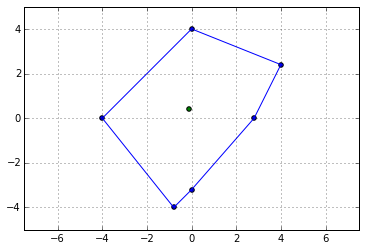

In [4]:
XCoords = np.array([-1,-0.2,0,0.7,1,0])*4
YCoords = np.array([0,-1,-.8,0,.6,1])*4
centre = [-0.1,0.4]

plt.scatter(XCoords, YCoords)
plt.scatter(centre[0],centre[1],c='g')
plt.plot(np.append(XCoords, XCoords[0]), 
         np.append(YCoords, YCoords[0]))
plt.axis("equal")
plt.grid(True)

In [5]:
straighenedCutout = straighten_cutout(x=XCoords, y=YCoords, centre=centre)

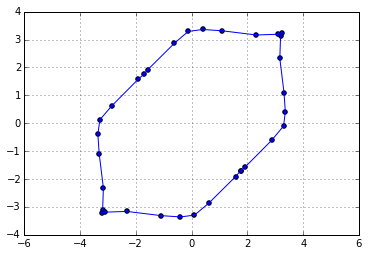

In [6]:
plt.plot(straighenedCutout.straightenedXCoords,
         straighenedCutout.straightenedYCoords,'-')
plt.scatter(straighenedCutout.straightenedXCoords,
            straighenedCutout.straightenedYCoords)
plt.axis("equal")
plt.grid(True)

(-5.0, 5.0, -5.0, 4.0)

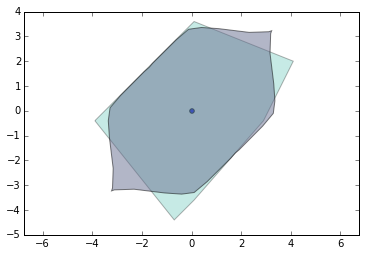

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

patch = des.PolygonPatch(straighenedCutout.centralCutout, fc=np.random.uniform(size=3), alpha=0.3)
ax.add_patch(patch)

patch = des.PolygonPatch(straighenedCutout.straightenedCutout, fc=np.random.uniform(size=3), alpha=0.5)
ax.add_patch(patch)

plt.scatter(0,0)

ax.set_xlim([-straighenedCutout.maxRadii,straighenedCutout.maxRadii])
ax.set_ylim([-straighenedCutout.maxRadii,straighenedCutout.maxRadii])
ax.axis("equal")

## Concepts used to program the straightening object

Maximum zone size calulcated from max dimension of bounding box times by $\sqrt{2}$

In [8]:
cutout = shapely_cutout(XCoords,YCoords)
centralCutout = aff.translate(cutout, xoff=-centre[0], yoff=-centre[1])
maxRadii = np.max(centralCutout.bounds) * np.sqrt(2)

(-6.0, 6.0, -6.0, 6.0)

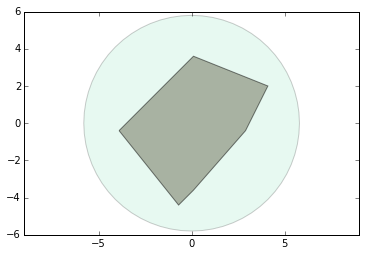

In [9]:
maxZone = geo.Point(0,0).buffer(maxRadii)


fig = plt.figure()
ax = fig.add_subplot(111)

patch1 = des.PolygonPatch(maxZone, fc=np.random.uniform(size=3), alpha=0.2)
ax.add_patch(patch1)

patch2 = des.PolygonPatch(centralCutout, fc=np.random.uniform(size=3), alpha=0.5)
ax.add_patch(patch2)


ax.set_xlim([-maxRadii,maxRadii])
ax.set_ylim([-maxRadii,maxRadii])
ax.axis("equal")

Example with 10 zones

(-6.0, 6.0, -6.0, 6.0)

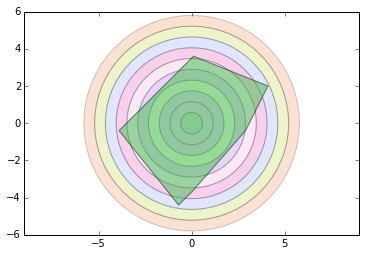

In [10]:
numZones = 10
zoneBoundaryRadii = np.linspace(0,maxRadii,numZones + 1)

zoneBoundaries = [0,]*(numZones+1)
zoneAreas = [0,]*numZones
zoneMidDist = (zoneBoundaryRadii[0:-1] + zoneBoundaryRadii[1:])/2

for i in range(numZones + 1):
    zoneBoundaries[i] = geo.Point(0,0).buffer(zoneBoundaryRadii[i])
    
for i in range(numZones):
    zoneAreas[i] = zoneBoundaries[i+1].difference(zoneBoundaries[i])


fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(numZones):
    patch = des.PolygonPatch(zoneAreas[i], fc=np.random.uniform(size=3), alpha=0.2)
    ax.add_patch(patch)


patch = des.PolygonPatch(centralCutout, fc=np.random.uniform(size=3), alpha=0.5)
ax.add_patch(patch)    
    
ax.set_xlim([-maxRadii,maxRadii])
ax.set_ylim([-maxRadii,maxRadii])
ax.axis("equal")

Actual zone creation (using 1000 instead of 10)

In [11]:
numZones = 1000
zoneBoundaryRadii = np.linspace(0,maxRadii,numZones + 1)

zoneBoundaries = [0,]*(numZones+1)
zoneRegion = [0,]*numZones
zoneMidDist = (zoneBoundaryRadii[0:-1] + zoneBoundaryRadii[1:])/2

for i in range(numZones + 1):
    zoneBoundaries[i] = geo.Point(0,0).buffer(zoneBoundaryRadii[i])
    
for i in range(numZones):
    zoneRegion[i] = zoneBoundaries[i+1].difference(zoneBoundaries[i])

Find the area contained within each zone

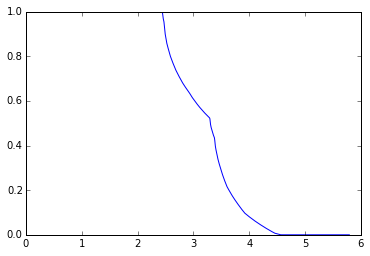

In [12]:
zoneRatioAreas = np.zeros(numZones)

for i in range(numZones):
    zoneRatioAreas[i] = centralCutout.intersection(zoneRegion[i]).area / zoneRegion[i].area
    
plt.plot(zoneMidDist, zoneRatioAreas)

The angles required to make the straightened shape

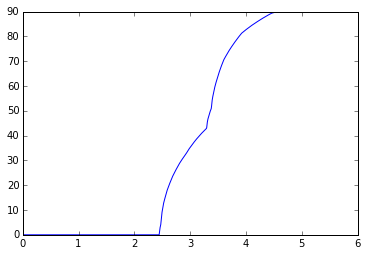

In [13]:
placementAngles = 90 - 90*zoneRatioAreas
plt.plot(zoneMidDist, placementAngles)

Define the shape of the sector

(0.0, 2.5, 0.0, 5.0)

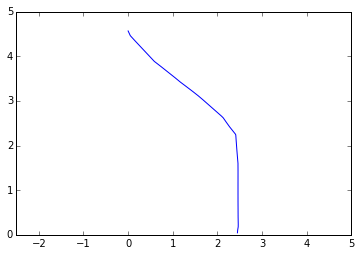

In [14]:
placePointRef = (placementAngles > 0) & (placementAngles < 90)

numSectorPoints = sum(placePointRef)
straightenedSectorX = np.zeros(numSectorPoints)
straightenedSectorY = np.zeros(numSectorPoints)

for i in range(numSectorPoints):
    
    hypot = zoneMidDist[placePointRef][i]
    angle = placementAngles[placePointRef][i]
    
    straightenedSectorX[i] = hypot * np.cos(np.pi/180 * angle)
    straightenedSectorY[i] = hypot * np.sin(np.pi/180 * angle)
    
    
plt.plot(straightenedSectorX,straightenedSectorY)

plt.axis("equal")

(-3.0, 3.0, -6.0, 6.0)

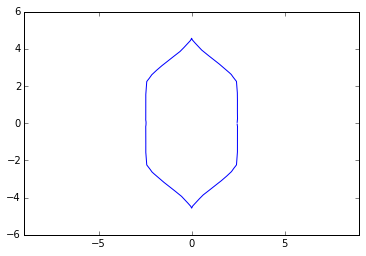

In [15]:
straightenedCoordsX = np.concatenate((straightenedSectorX, 
                                      -straightenedSectorX[::-1],
                                      -straightenedSectorX,
                                      straightenedSectorX[::-1]))

straightenedCoordsY = np.concatenate((straightenedSectorY, 
                                      straightenedSectorY[::-1],
                                      -straightenedSectorY,
                                      -straightenedSectorY[::-1]))

plt.plot(straightenedCoordsX,straightenedCoordsY)

plt.axis("equal")

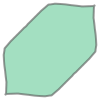

In [16]:
straightenedCutout = aff.rotate(shapely_cutout(straightenedCoordsX,straightenedCoordsY),-45)
straightenedCutout

(-4.0, 4.0, -4.0, 4.0)

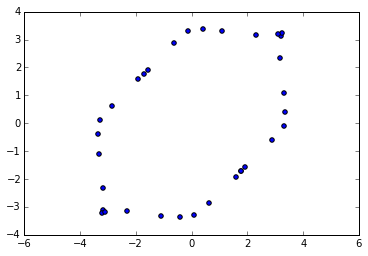

In [17]:
strCutoutXY = straightenedCutout.simplify(0.01).exterior.xy

plt.scatter(strCutoutXY[0],strCutoutXY[1])
plt.axis("equal")

In [18]:
diffCheck = shapely_cutout(strCutoutXY[0],strCutoutXY[1])
(diffCheck.difference(straightenedCutout).area + 
 straightenedCutout.difference(diffCheck).area) / straightenedCutout.area

0.001305891499137194